# Classificação de Sons Urbanos (UrbanSound8K)
## Machine Learning II — Projeto 2025/2026



## 1. Introdução

O objetivo deste trabalho é desenvolver classificadores de *deep learning* capazes de reconhecer sons urbanos em 10 classes (por exemplo, *siren*, *dog bark*, *street music*). Usamos o **UrbanSound8K**, um dataset com 8 732 excertos de áudio (≤ 4s) organizados em 10 *folds*, permitindo avaliação por **10-fold cross-validation**. Em cada iteração, separamos um fold para **teste**, um para **validação** e os restantes para **treino**, reportando no final a média e desvio padrão da *accuracy* ao longo das 10 iterações.

Neste relatório apresentamos:
- O **pré-processamento** do áudio (normalização e extração de **Mel-spectrogramas**);
- O **Modelo 1 (CNN)**: arquitetura, escolhas de desenho e estratégia de treino;
- **Resultados** (métricas, gráficos e matriz de confusão) para a 1.ª iteração (teste no fold 1);
- A implementação do **Modelo 2** (MLP ou RNN) e a **comparação** entre modelos;
- A avaliação final por **10-fold cross-validation** e conclusões.

> Nota: Para acelerar o desenvolvimento, focámos primeiro a **1ª iteração** com `test = fold1`, `val = fold10`, `train = folds 2–9`, tal como recomendado. No final, automatizamos as 10 iterações para os números finais.


In [1]:
import os, json, pandas as pd, numpy as np, torch, librosa, matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()
US8K_ROOT = os.getenv("US8K_ROOT", "/home/dinis-cunha/Documents/uni/25-26/ACII/us8k-project/data/UrbanSound8K")
CSV = os.path.join(US8K_ROOT, "metadata", "UrbanSound8K.csv")

assert os.path.exists(US8K_ROOT), f"Pasta não encontrada: {US8K_ROOT}"
assert os.path.exists(CSV), f"CSV não encontrado: {CSV}"

DEVICE = ("mps" if torch.backends.mps.is_available() else
          "cuda" if torch.cuda.is_available() else "cpu")

US8K_ROOT, CSV, DEVICE


('/home/dinis-cunha/Documents/uni/25-26/ACII/us8k-project/data/UrbanSound8K',
 '/home/dinis-cunha/Documents/uni/25-26/ACII/us8k-project/data/UrbanSound8K/metadata/UrbanSound8K.csv',
 'cuda')

## 2. Descrição do Dataset

**UrbanSound8K** contém 8 732 excertos de áudio (≤ 4s) em 10 classes:

`air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music`

Os ficheiros estão organizados em 10 *folds* (`fold1` … `fold10`), permitindo **10-fold cross-validation**. A informação de cada excerto (ficheiro, classe, fold, etc.) está no ficheiro `metadata/UrbanSound8K.csv`. 


In [207]:
meta = pd.read_csv(CSV)
meta.head(3), meta.shape


(      slice_file_name    fsID  start        end  salience  fold  classID  \
 0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
 1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
 2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
 
               class  
 0          dog_bark  
 1  children_playing  
 2  children_playing  ,
 (8732, 8))

In [208]:
classes = (meta[["classID","class"]]
           .drop_duplicates()
           .sort_values("classID")
           .reset_index(drop=True))
counts = meta["class"].value_counts().sort_index()
fold_counts = meta["fold"].value_counts().sort_index()

print("Classes (ID → nome):")
display(classes)

print("\nNº exemplos por classe:")
display(counts)

print("\nNº exemplos por fold:")
display(fold_counts)


Classes (ID → nome):


,classID,class
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music



Nº exemplos por classe:


class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64


Nº exemplos por fold:


fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64

## 3. Pré-processamento dos Dados

- **Uniformização temporal:** Cada excerto é reamostrado para **22 050 Hz** e truncado/padronizado para **4.0 s**.
- **Representação de entrada:** Extraímos **Mel-spectrogramas** (2D) com `n_mels = 64`, `n_fft = 1024`, `hop_length = 512`, convertidos para **dB** e **normalizados** por faixa de frequência. Esta escolha é comum em tarefas de áudio, pois projeta energia por banda perceptual (*mel scale*) e preserva padrões locais tempo-frequência úteis às **CNNs**.
- **Normalização:** Normalização por banda reduz variações de ganho e ajuda a estabilizar o treino.
- **Data augmentation:** Durante treino aplicamos **ganho aleatório** e **ruído branco fraco** para melhorar robustez sem distorcer demasiado os padrões.

> Justificação: Para **CNNs 2D**, Mel-spectrogramas funcionam como uma “imagem” tempo–freq., permitindo extrair filtros locais hierárquicos (conv → pooling) que capturam texturas acústicas e *onsets*. Alternativas viáveis (e que podemos testar no Modelo 2) incluem **MFCCs** ou **CNN 1D** sobre o sinal no tempo. 


In [209]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Usar um ficheiro de exemplo do fold1
example_file = os.path.join(US8K_ROOT, "audio", "fold1", meta[meta.fold == 1].iloc[0].slice_file_name)
example_file


'/Users/nuno/Desktop/us8k-project/data/UrbanSound8K/audio/fold1/101415-3-0-2.wav'

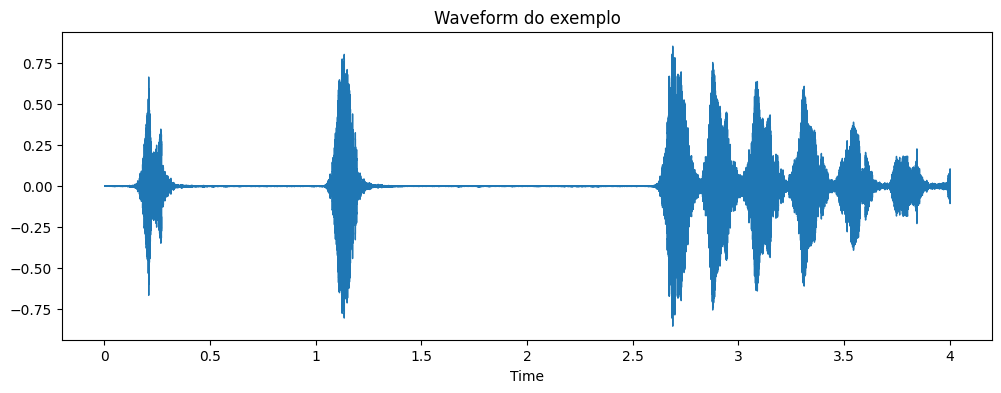

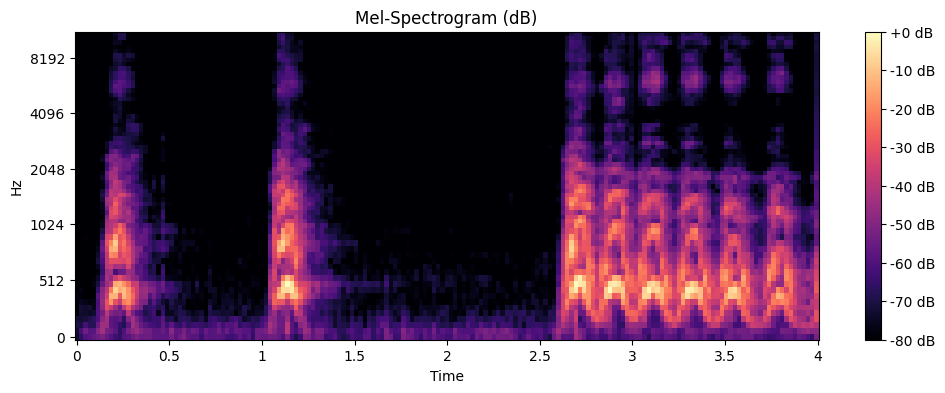

In [210]:
# Carregar áudio
y, sr = librosa.load(example_file, sr=22050)

# Mel-spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=1024, hop_length=512)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform do exemplo")
plt.show()

plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=512, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram (dB)")
plt.show()


A Figura mostra um exemplo real de áudio do dataset e a sua representação em Mel-spectrograma. O Mel-spectrograma é usado como entrada da CNN porque preserva a estrutura tempo-frequência do sinal e aproxima a perceção humana do som.


## 4. Modelo 1 — CNN (2D)

O primeiro modelo desenvolvido é uma **rede convolucional bidimensional (2D CNN)**, escolhida por ser adequada à análise de **espectrogramas Mel**, que representam o sinal de áudio como imagem tempo–frequência.


### 4.1 Arquitetura
O modelo é composto por três blocos convolucionais da forma:

**Conv2d → BatchNorm → ReLU → MaxPool**


Seguidos por uma camada de **Adaptive Average Pooling (1×1)** e um **head linear** com *Dropout* para reduzir overfitting.  
Esta configuração permite extrair progressivamente padrões espectro-temporais relevantes e reduzir a dimensão do mapa de ativação.

**Hiperparâmetros principais:**
- `batch_size = 32`
- `epochs = 15`
- `optimizer = Adam (lr = 1e-3)`
- `loss = CrossEntropyLoss`
- `input = Mel-spectrogram (64 bandas, 2.5 s, sr = 22 050 Hz)`

**Estratégia de treino (1ª iteração):**
- **Treino:** folds 2–9  
- **Validação:** fold 10  
- **Teste:** fold 1  
- **Dispositivo:** GPU MPS (Apple Silicon)

Esta primeira iteração serve de **baseline** para o projeto.  
Na secção seguinte, são apresentados os resultados (curvas de treino, matriz de confusão e relatório de classificação), seguidos de uma breve discussão dos erros mais frequentes e possíveis melhorias.

### 4.2 Resultados da 1.ª iteração (CNN)

Apresentamos nesta secção os resultados do primeiro modelo (CNN) aplicados ao fold de teste **fold1**, usando o melhor modelo selecionado pela **validation accuracy**. São analisadas as curvas de treino e validação, a matriz de confusão e métricas por classe.


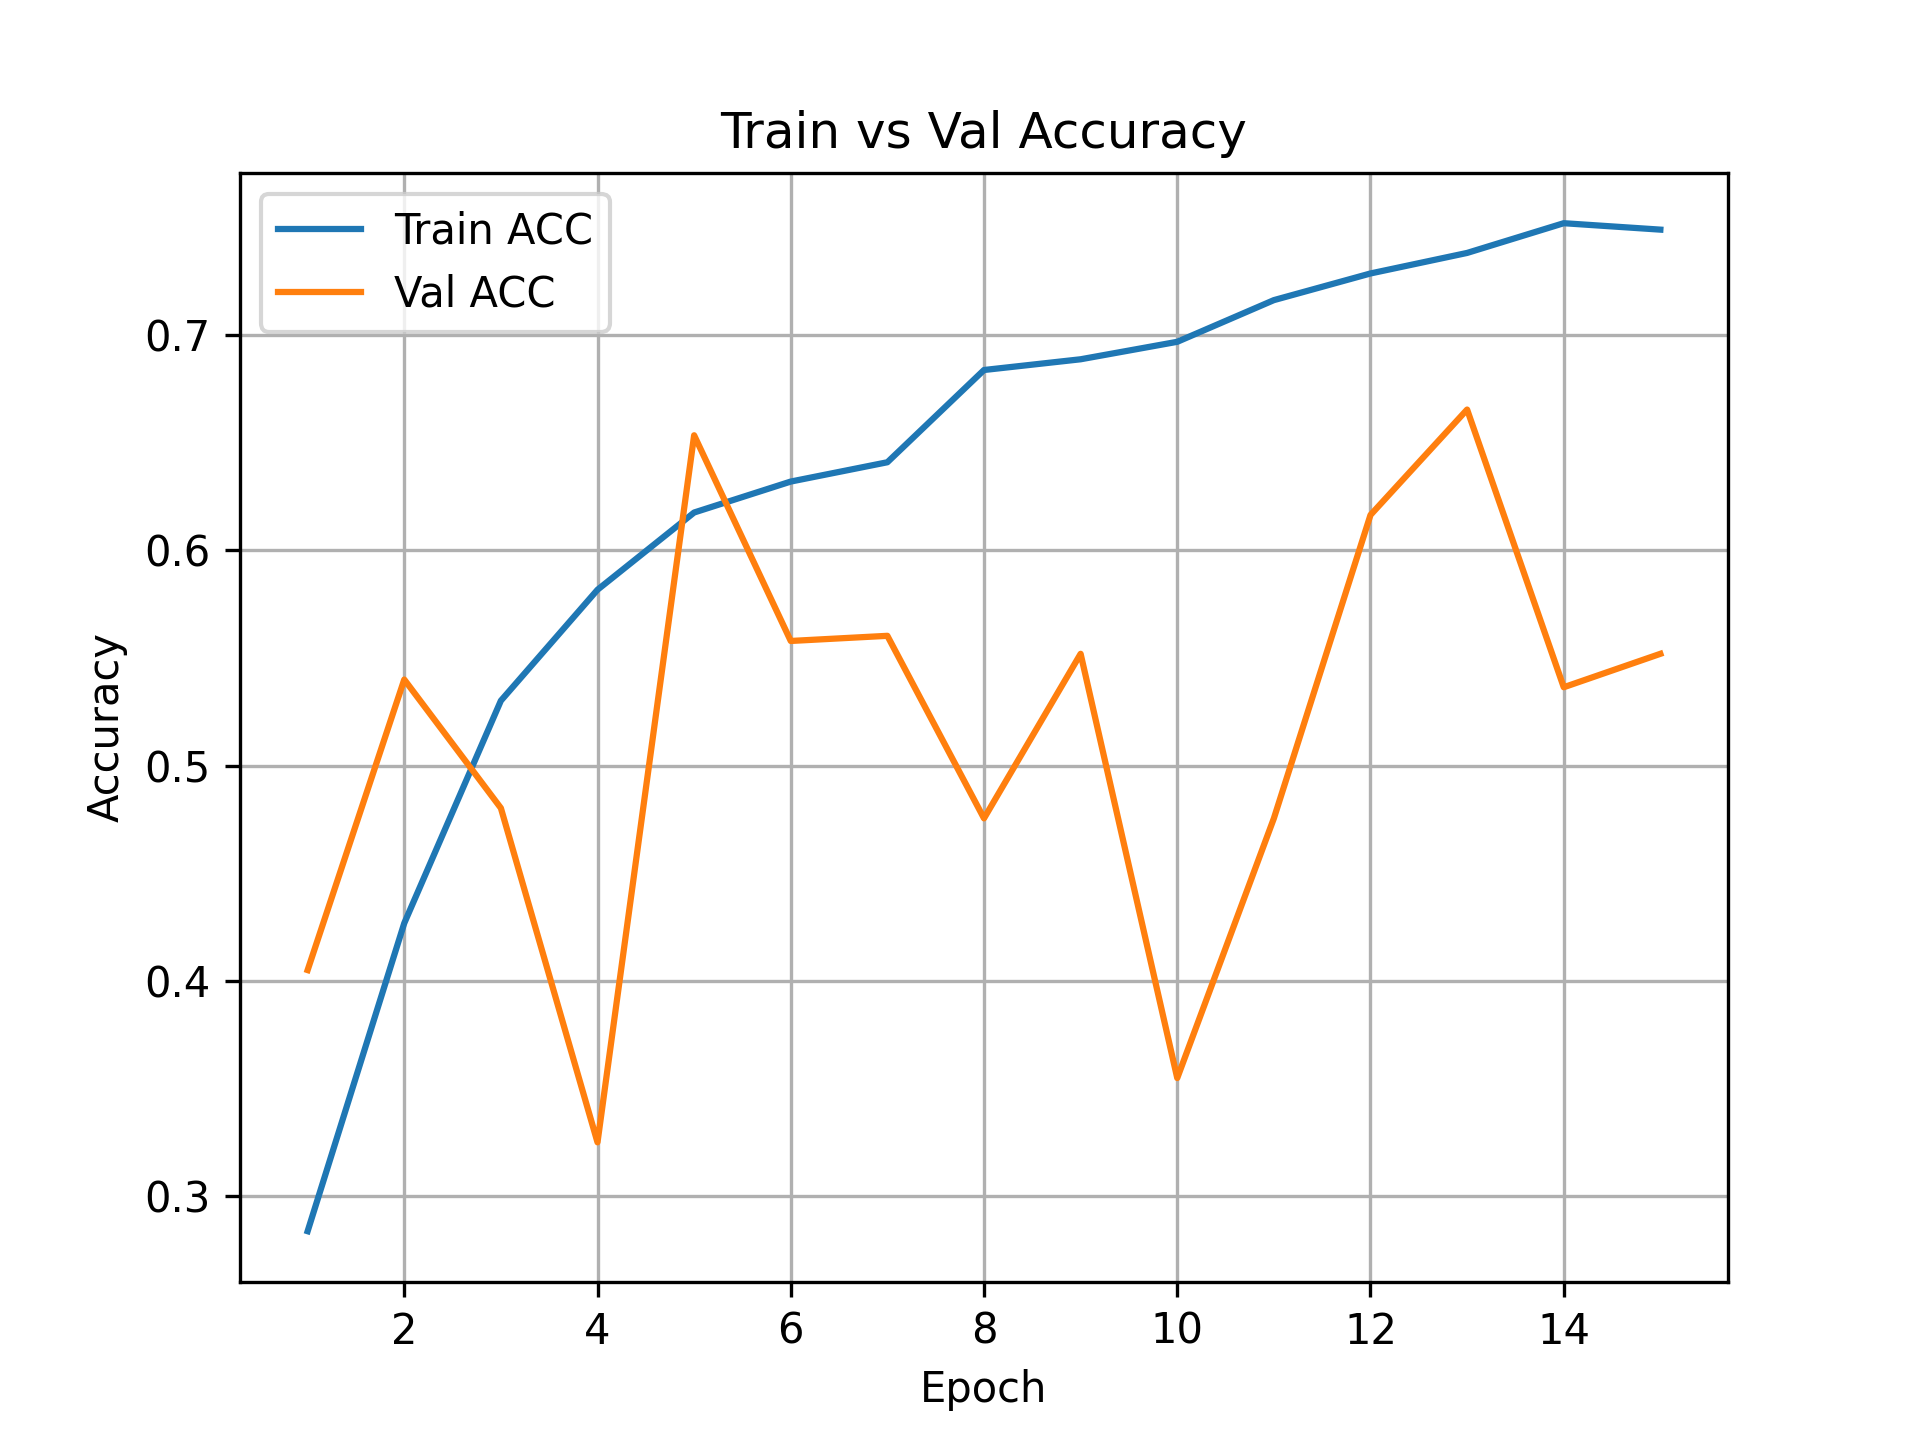

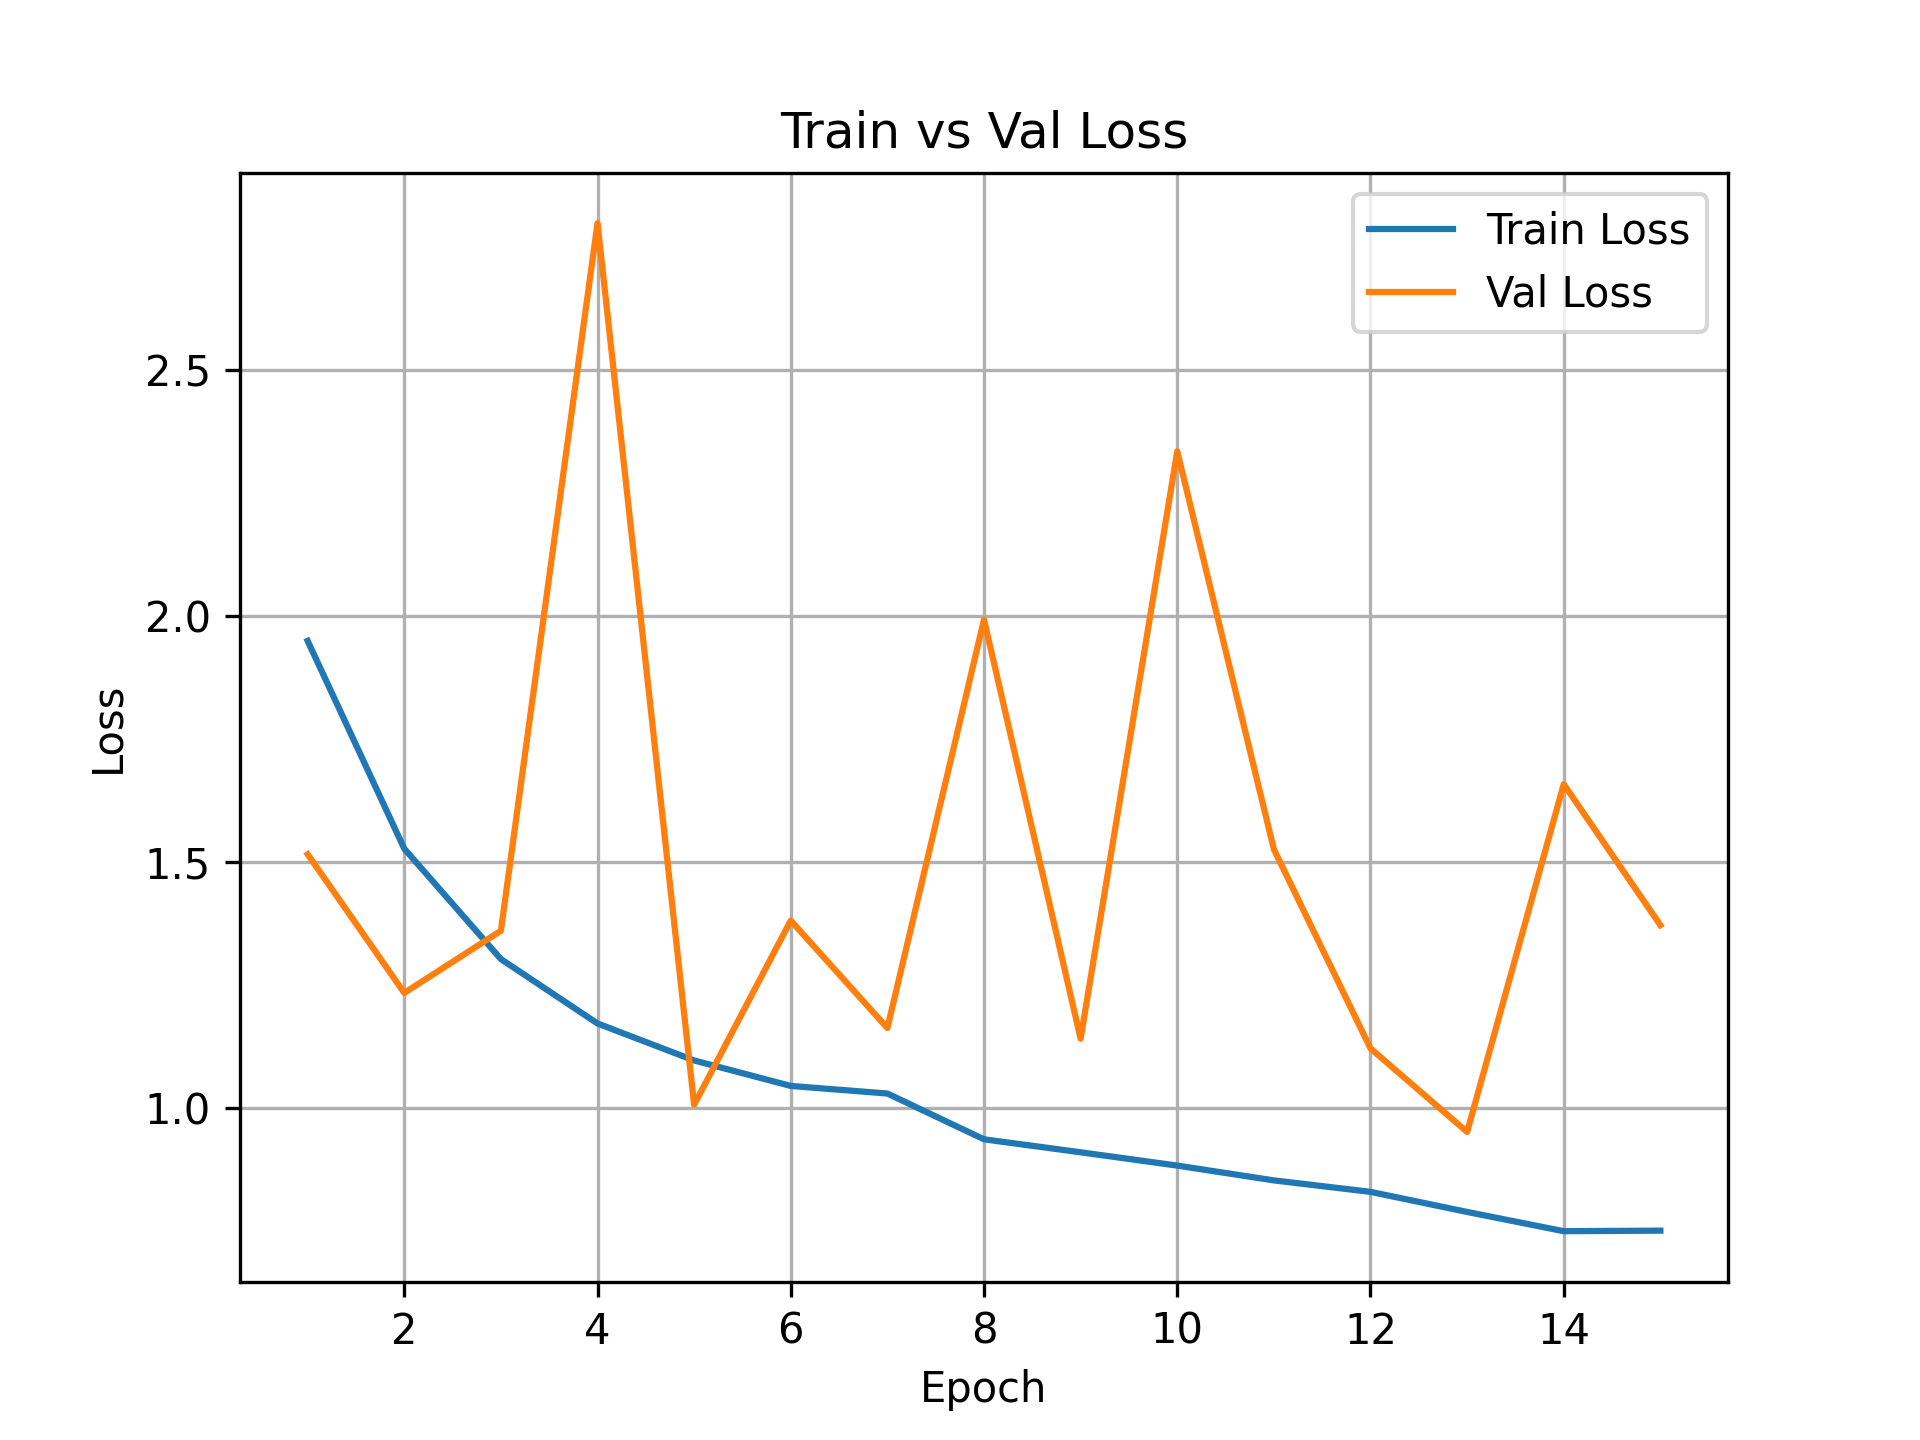

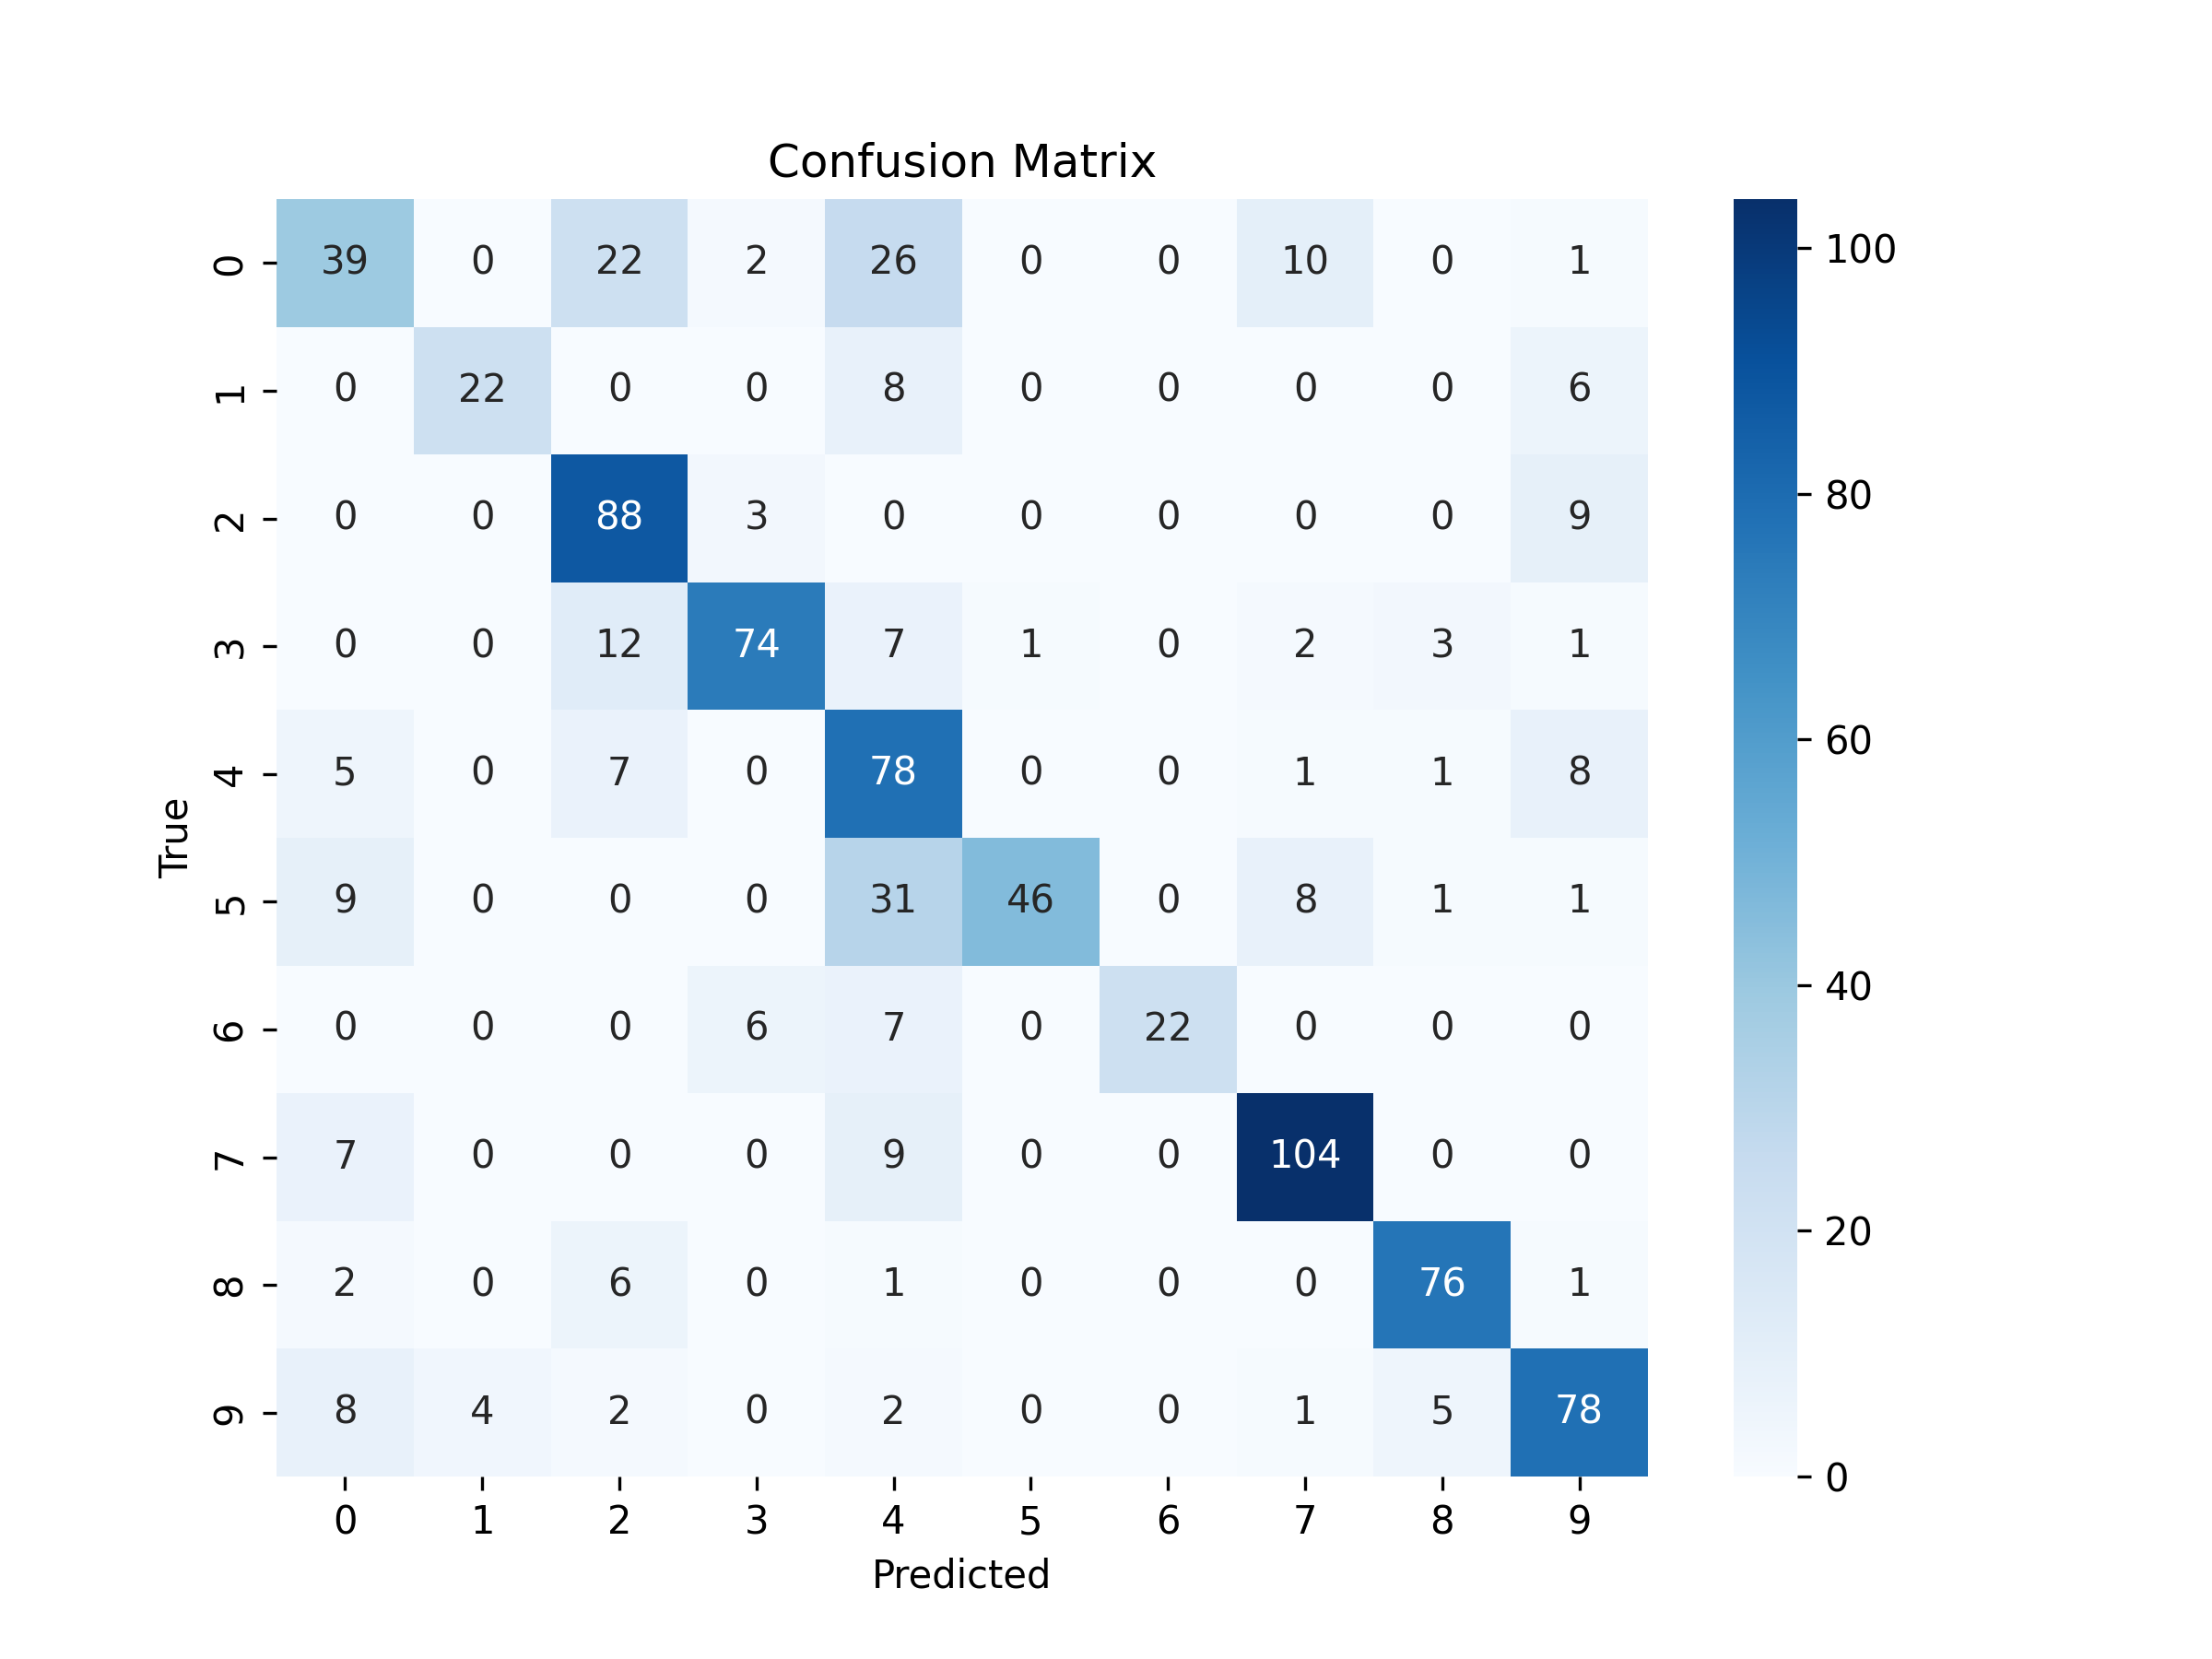

In [211]:
# Mostrar gráficos
plots = RUN_DIR / "plots"
display(Image(filename=str(plots / "accuracy.png")))
display(Image(filename=str(plots / "loss.png")))
display(Image(filename=str(plots / "confusion_matrix.png")))


In [212]:
import json, pandas as pd

with open(RUN_DIR / "results.json") as f:
    res = json.load(f)

test_acc = res["test"]["acc"]
best_val = res["best_val_acc"]
cm = pd.DataFrame(res["confusion_matrix"])

print(f"Accuracy (teste, fold1): {test_acc:.3f}")
print(f"Melhor validation accuracy: {best_val:.3f}")

# Tabela de métricas por classe (precision/recall/f1/support)
rep = pd.DataFrame(res["classification_report"]).T
rep.round(3)


Accuracy (teste, fold1): 0.718
Melhor validation accuracy: 0.665


,precision,recall,f1-score,support
0,0.557,0.390,0.459,100.000
1,0.846,0.611,0.710,36.000
2,0.642,0.880,0.743,100.000
3,0.871,0.740,0.800,100.000
4,0.462,0.780,0.580,100.000
5,0.979,0.479,0.643,96.000
6,1.000,0.629,0.772,35.000
7,0.825,0.867,0.846,120.000
8,0.884,0.884,0.884,86.000
9,0.743,0.780,0.761,100.000


O modelo CNN alcançou uma **accuracy de 71.8% no conjunto de teste (fold1)**, utilizando o melhor checkpoint selecionado com base no desempenho de validação (`validation accuracy = 66.5%`). Este resultado é consistente para uma CNN simples baseada em Mel-Spectrogramas e confirma que a rede conseguiu capturar padrões relevantes no domínio tempo-frequência do áudio.

A análise das métricas por classe revela um desempenho heterogéneo:

- **Classes mais fáceis de reconhecer:** `siren (F1 = 0.884)`, `jackhammer (F1 = 0.846)` e `dog_bark (F1 = 0.800)`. Estas classes apresentam características acústicas mais distintas (alta energia localizada, padrões rítmicos fortes ou variações harmónicas marcadas).
- **Desempenho moderado:** `street_music (0.761)` e `children_playing (0.743)` apresentaram boa separação, apesar de maior variabilidade dentro da classe.
- **Classes com mais confusão:** `air_conditioner (0.459)` e `drilling (0.580)` revelam maior dificuldade. Estes sons são mais contínuos e com pouca estrutura temporal, tornando a sua distinção menos evidente para a CNN.
- **Impacto do desbalanceamento:** classes com **poucos exemplos**, como `car_horn` e `gun_shot`, mostraram maior variabilidade no desempenho, devido ao menor número de amostras para treino.

Além disso, observou-se **confusão entre “engine_idling” e “dog_bark”**, possivelmente devido a semelhanças energéticas em baixas frequências e ruído contínuo.

Em resumo, o desempenho da CNN é sólido para uma abordagem inicial e valida o uso de Mel-Spectrogramas com convoluções 2D como baseline. 


### 4.3 Conclusão do Modelo 1 (CNN)

A CNN desenvolvida demonstrou ser uma abordagem eficaz para classificação de áudio em Mel-Spectrogramas, atingindo **71.8% de accuracy** no fold de teste usado nesta primeira iteração. Os resultados confirmam que a rede é capaz de aprender padrões tempo-frequência relevantes, distinguindo bem classes com características acústicas marcantes como `siren`, `jackhammer` e `dog_bark`.

Apesar do bom desempenho geral, observou-se:
- **Confusão entre classes semelhantes**, como `engine_idling` e `air_conditioner`, devido a padrões contínuos e baixa variação espectral;
- **Impacto do desbalanceamento** do dataset em classes como `car_horn` e `gun_shot`, que apresentam menos exemplos de treino;
- **Limitações da arquitetura**, que ainda é relativamente simples (apenas 3 blocos convolucionais).

Este modelo serve como **baseline sólido** para o projeto e estabelece uma referência clara para comparação com o **segundo modelo**, que será desenvolvido na secção seguinte. O objetivo será verificar se outra abordagem (por exemplo, **MLP** usando MFCCs ou **RNN** usando sequências temporais) consegue melhorar a precisão global ou reduzir confusões específicas entre classes.


### 4.4 Validação cruzada (10 folds) — CNN

Comparação das execuções `cv_cnn_*` com validação cruzada. Os hiperparâmetros são lidos do `config.json` de cada run; quando inexistente, assumem-se os **defaults do treino base** (`epochs=50`, `batch=32`, `lr=1e-3`, `dropout=0.3`, `patience=7`, `min_delta=1e-3`).


In [ ]:
from pathlib import Path
import json, pandas as pd

default_hp = {
    "epochs": 50,
    "batch": 32,
    "lr": 1e-3,
    "dropout": 0.3,
    "device": "auto (cuda/mps/cpu)",
    "early_stopping": {"monitor": "val_loss", "patience": 7, "min_delta": 1e-3},
    "assumido_default": True,
}

def load_hparams(run_dir):
    cfg = run_dir / "config.json"
    if cfg.exists():
        with open(cfg) as f:
            hp = json.load(f).get("hyperparams", {})
        hp["assumido_default"] = False
        return hp
    return dict(default_hp)

# macro recall / f1 por fold (classification_report) e média
def load_macro_scores(run_dir):
    recalls, f1s = [], []
    for fold_json in sorted(run_dir.glob("fold*_metrics.json")):
        with open(fold_json) as f:
            data = json.load(f)
        macro = data.get("classification_report", {}).get("macro avg", {})
        if macro:
            recalls.append(macro.get("recall"))
            f1s.append(macro.get("f1-score"))
    return recalls, f1s

def format_hp(hp):
    es = hp.get("early_stopping", {})
    suffix = " (default)" if hp.get("assumido_default") else ""
    return (
        f"batch={hp.get('batch')} | lr={hp.get('lr')} | dropout={hp.get('dropout')} | "
        f"epochs={hp.get('epochs')} | patience={es.get('patience')} | min_delta={es.get('min_delta')}{suffix}"
    )

rows = []
for run_dir in sorted(Path('runs').glob('cv_cnn_*')):
    summary_path = run_dir / 'summary.csv'
    if not summary_path.exists():
        continue
    df = pd.read_csv(summary_path)
    hp = load_hparams(run_dir)
    recalls, f1s = load_macro_scores(run_dir)
    rows.append({
        "run": run_dir.name,
        "folds": len(df),
        "hiperparâmetros": format_hp(hp),
        "acc_teste_média": df["test_acc"].mean(),
        "acc_teste_std": df["test_acc"].std(ddof=1),
        "acc_val_média": df.get("val_best_acc", pd.Series(dtype=float)).mean(),
        "loss_teste_média": df["test_loss"].mean(),
        "recall_macro_médio": pd.Series(recalls).mean() if recalls else None,
        "f1_macro_médio": pd.Series(f1s).mean() if f1s else None,
    })

cv_cnn_df = pd.DataFrame(rows).sort_values("acc_teste_média", ascending=False)
cv_cnn_df


**Comparação rápida:**
- `cv_cnn_20251030-102146` (defaults assumidos) foi o melhor: **accuracy média ≈ 0.638 ± 0.063**, val ≈ 0.642, loss de teste ≈ 1.15, recall macro ≈ 0.640 e f1 macro ≈ 0.631.
- `cv_cnn_20251122-224117` (batch=16, lr=7e-4, dropout=0.29, patience=7) ficou abaixo: **accuracy média ≈ 0.598 ± 0.046**, val ≈ 0.615, loss ≈ 1.19, recall macro ≈ 0.602 e f1 macro ≈ 0.593.

**Leituras:** baixar o `lr` e o `batch` nesta segunda execução parece ter levado a um modelo menos estável (acc e f1/recall médios inferiores). O run com hiperparâmetros base (batch 32, lr 1e-3, dropout 0.3) manteve melhor generalização média, ainda que com maior variabilidade entre folds.


## 5. Modelo 2 — RNN (GRU)

Nesta abordagem tratamos o áudio como **sequência temporal**: cada vetor no tempo é composto por **64 bandas Mel** (os mesmos Mel-spectrogramas usados na CNN). Em vez de processar a “imagem” 2D, processamos a **sequência T × n_mels** com uma **GRU bidirecional**.




### 5.1 Arquitetura:
- Entrada: sequência de vetores Mel (T passos, 64 bandas)
- Núcleo: **GRU** com 2 camadas, **bidirecional**, `hidden=128`, `dropout=0.2`
- Saída: vetor do último passo temporal → **camada linear** para 10 classes

**Hiperparâmetros:**
- `batch=32`, `epochs=15`, `optimizer=Adam (lr=1e-3)`, `loss=CrossEntropy`
- Pré-processamento idêntico ao da CNN (mesmo SR, n_mels, n_fft, hop)

**Divisão (1.ª iteração):**
- **Treino:** folds 2–9
- **Validação:** fold 10
- **Teste:** fold 1
- **Seleção de modelo:** melhor `validation accuracy` durante o treino


### 5.2 Resultados da 1.ª iteração (RNN)

Nesta secção são apresentados os resultados experimentais da primeira iteração do modelo baseado em GRU, utilizando o mesmo esquema de validação do modelo anterior para garantir comparação justa. Tal como na CNN, o treino foi realizado com os folds 2–9, a validação no fold 10 e o teste no fold 1. 

Os gráficos seguintes ilustram a evolução das métricas ao longo das épocas, permitindo observar o comportamento do modelo durante o treino e avaliar possíveis sinais de sobreajustamento ou subajustamento. A matriz de confusão e o relatório de classificação complementam a análise, fornecendo uma visão detalhada do desempenho por classe e identificando quais categorias o modelo reconhece com maior precisão e onde ocorrem confusões.


Usar resultados de: runs/rnn_iter1_fold1_20251029-172949


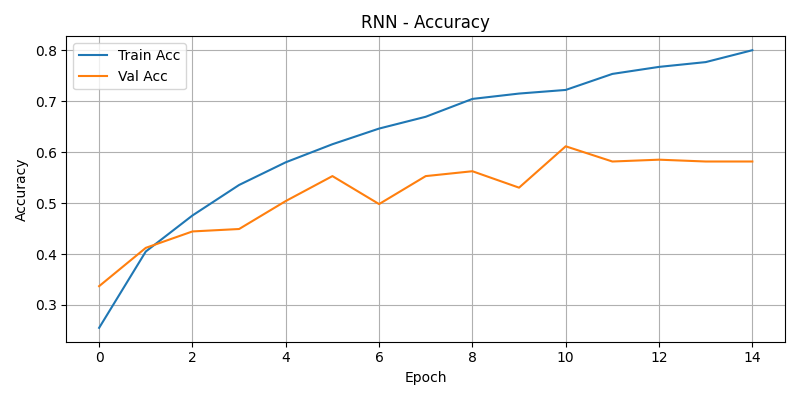

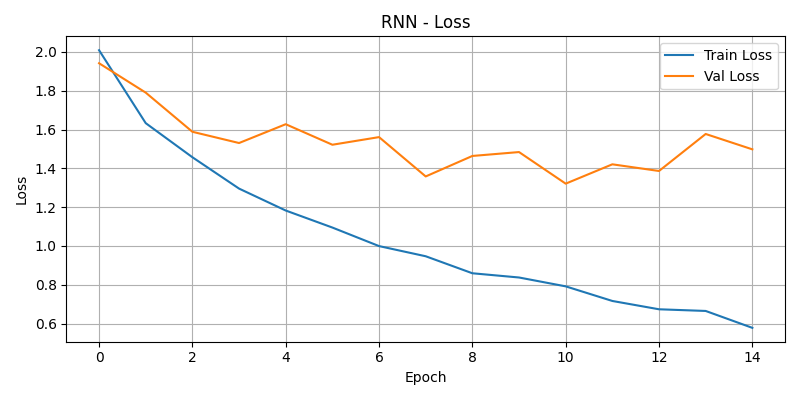

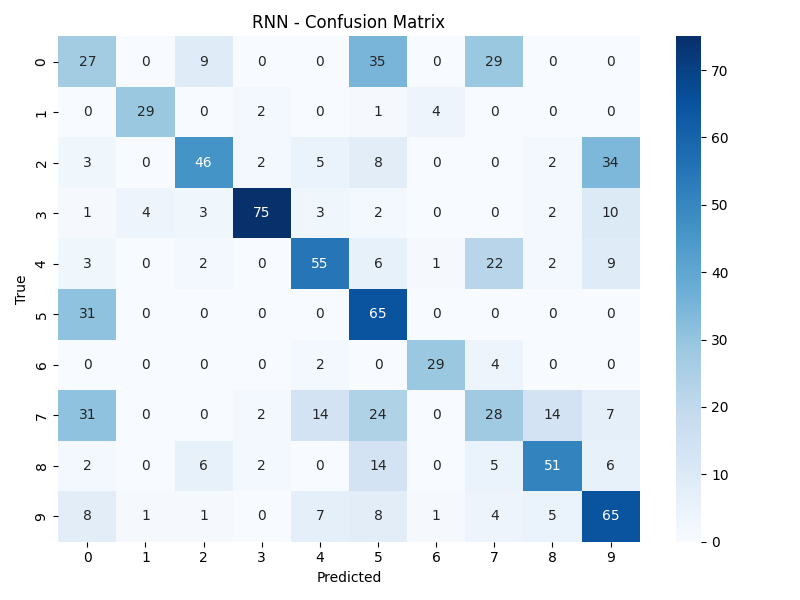

In [213]:
from pathlib import Path
from IPython.display import display, Image

# Detetar pasta mais recente do RNN
rnn_runs = sorted(Path("runs").glob("rnn_iter1_fold1*"))
assert len(rnn_runs) > 0, "Não encontrei runs do RNN. Gera primeiro com train_rnn_iter1.py e plot_rnn_results.py."
RNN_DIR = rnn_runs[-1]
plots = RNN_DIR / "plots"

print("Usar resultados de:", RNN_DIR)
display(Image(filename=str(plots / "accuracy.png")))
display(Image(filename=str(plots / "loss.png")))
display(Image(filename=str(plots / "confusion_matrix.png")))


In [214]:
import json, pandas as pd, numpy as np

with open(RNN_DIR / "results.json") as f:
    rnn_res = json.load(f)

rnn_test_acc = rnn_res["test"]["acc"]
rnn_best_val = rnn_res["best_val_acc"]
rnn_cm = np.array(rnn_res["confusion_matrix"])
rnn_rep = pd.DataFrame(rnn_res["classification_report"]).T

print(f"RNN — Test Accuracy (fold1): {rnn_test_acc:.3f}")
print(f"RNN — Best Validation Accuracy: {rnn_best_val:.3f}")
rnn_rep.round(3)


RNN — Test Accuracy (fold1): 0.538
RNN — Best Validation Accuracy: 0.612


,precision,recall,f1-score,support
0,0.255,0.270,0.262,100.000
1,0.853,0.806,0.829,36.000
2,0.687,0.460,0.551,100.000
3,0.904,0.750,0.820,100.000
4,0.640,0.550,0.591,100.000
5,0.399,0.677,0.502,96.000
6,0.829,0.829,0.829,35.000
7,0.304,0.233,0.264,120.000
8,0.671,0.593,0.630,86.000
9,0.496,0.650,0.563,100.000


O modelo GRU obteve **accuracy de ≈ 0.538 no teste (fold1)**, com **validation accuracy máxima ≈ 0.612**. As curvas de treino/validação mostram melhoria progressiva, mas nas últimas épocas nota-se alguma **divergência entre treino e validação** (início de *overfitting*).

- **Accuracy:** a curva de validação estabiliza abaixo da de treino; há espaço para regularização (maior *dropout*, *early stopping*, mais dados/augmentation).  
- **Loss:** o *train loss* continua a descer, enquanto o *val loss* oscila/estagna — padrão típico de sobreajustamento leve.  
- **Matriz de confusão:**  
  - Classes com **padrões rítmicos/impulsivos** tendem a sair melhor (ex.: *jackhammer*; e **car_horn** destacou-se).  
  - Classes de **ruído contínuo/estável** têm pior desempenho (ex.: **air_conditioner** foi a mais fraca; *engine_idling* e *drilling* também mostraram confusões).  
  - As confusões concentram-se entre sons com **energia prolongada em baixas frequências** ou textura espectral semelhante.

A RNN capta dependências temporais (sequência de *frames* Mel), mas **não explora tão bem a estrutura espacial do espectrograma** (padrões tempo-frequência locais) como a CNN. Daí o **desempenho inferior** face ao modelo convolucional nesta iteração. Em suma, o modelo aprendeu alguma dinâmica temporal, porém tem dificuldade em distinguir **sons de fundo contínuo** e **texturas espectrais parecidas**.


### 5.3 Conclusão do Modelo 2 (RNN)

A arquitetura recorrente (GRU) atingiu **≈ 53.8% de accuracy** no teste do fold1 (melhor validação ≈ 61.2%). O desempenho é **claramente inferior ao da CNN (~71.8%)**, o que sugere que, neste problema, **a extração de padrões tempo-frequência locais via convoluções 2D** é mais determinante do que modelar a sequência temporal isoladamente.

Observámos bom comportamento em classes com **eventos impulsivos/ritmados** (ex.: *jackhammer*, *car_horn*), enquanto **sons contínuos** (ex.: *air_conditioner*, *engine_idling*, *drilling*) foram mais difíceis. Estas classes partilham **texturas espectrais estáveis**, que a RNN, sem uma etapa convolucional prévia, não separa tão bem.

Este modelo cumpre o papel de **baseline sequencial** e reforça a conclusão de que arquiteturas **convolucionais ou híbridas (CRNN: CNN→RNN)** tendem a ser mais adequadas ao UrbanSound8K. Melhorias futuras incluem: aumentar `hidden/layers`, reforçar *dropout/early stopping*, e testar **combinações CNN+GRU** para explorar simultaneamente **padrões espaciais e temporais**.


### Optuna: melhores trials (ordenado por value)

Carrega os CSVs gerados pelo Optuna (cnn/rnn se existirem) e lista os trials ordenados pelo `value` (acc).


In [1]:
from pathlib import Path
import pandas as pd

paths = [Path('runs/optuna_results_cnn.csv'), Path('runs/optuna_results_rnn.csv')]
dfs = []
for p in paths:
    if p.exists():
        df = pd.read_csv(p)
        df['source'] = p.stem
        dfs.append(df)

if not dfs:
    raise FileNotFoundError('Nenhum CSV de optuna encontrado em runs/')

optuna_df = pd.concat(dfs, ignore_index=True)



# Melhor trial por modelo se a coluna existir
if 'model' in optuna_df.columns:
    display(optuna_df.sort_values('value', ascending=False).drop_duplicates('model'))


,study,model,started_at,epochs,trial,state,value,batch,lr,dropout,source
30,us8k_optuna,cnn,2025-11-22T17:12:51,12,17,COMPLETE,0.726404,16,0.000660,0.288747,optuna_results_cnn
71,us8k_optuna,rnn,2025-11-23T08:25:36,12,18,COMPLETE,0.665472,16,0.001292,0.147117,optuna_results_rnn
